In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import pandas as pd
from ipywidgets import interact, IntSlider
import glob

In [2]:
def get_data(logs_dir):
    logs = sorted(glob.glob(f"{logs_dir}/V*"), key=lambda x: float(x.split('/')[-1].split('_')[-1]))
    v = [float(log.split('/')[-1].split('_')[-1]) for log in logs]
    freqs = []
    hists = []
    profs = []
    for log in logs:
        freqs.append(pd.read_table(glob.glob(f"{log}/profile*-freqs.dat")[0], skiprows=5, sep='\s+'))
        hists.append(pd.read_table(glob.glob(f"{log}/history.data")[0], skiprows=5, sep='\s+'))
        profs.append(pd.read_table(glob.glob(f"{log}/profile*.data.GYRE")[0], skiprows=5, sep='\s+'))
    return v, freqs, hists, profs

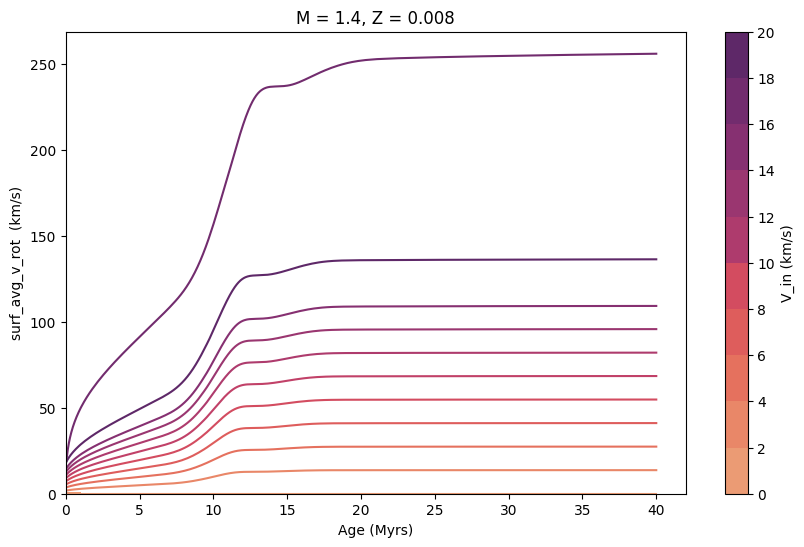

In [3]:
def hist_plots(logs_dir, col, unit='', v_selected=[], logarithmic=True):
    v, freqs, hists, profs = get_data(logs_dir)
    plt.figure(figsize=(10, 6))
    if v_selected == []:
        v_selected = v
    with sns.color_palette("flare", n_colors=len(v_selected)) as palette:
        cmap = mpl.colors.ListedColormap(palette)
        for v_i in range(len(v)):
            if v[v_i] in v_selected:
                t = hists[v_i]['star_age']/1e6
                if logarithmic:
                    plt.plot(t, 10**hists[v_i][col], label=f"V_in = {v[v_i]} {unit}")
                else:
                    plt.plot(t, hists[v_i][col], label=f"V_in = {v[v_i]} {unit}")
        
    plt.xlabel('Age (Myrs)')
    if unit != '':
        unit = f"  ({unit})"
    if logarithmic:
        plt.ylabel(' '.join(col.split("_")[1:])+unit)
    else:
        plt.ylabel(col+unit)
    Z = [[0,0],[0,0]]
    levels = range(0, 22, 2)
    contour = plt.contourf(Z, levels, cmap=cmap)
    plt.colorbar(contour, ticks=v, boundaries=np.arange(len(v_selected)+1)-0.5, label='V_in (km/s)')
    M = logs_dir.split('_')[-2].split('M')[-1]
    Z = logs_dir.split('_')[-1].split('Z')[-1]
    plt.title(f'M = {M}, Z = {Z}')
    # plt.legend()
    # plt.show()


hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'surf_avg_v_rot', unit="km/s", logarithmic=False)
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'log_cntr_Rho')
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'log_R', unit="RSun")
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'log_cntr_T', logarithmic=False)
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'log_cntr_P', logarithmic=False)
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'delta_nu', logarithmic=False)
# hist_plots('tests_here/test_profiles_M1.4_Z0.008', 'nu_max', logarithmic=False)

# logs_dirs = glob.glob('tests_here/test_profiles_M1.4_Z*')
# for logs_dir in logs_dirs:
#     col = 'surf_avg_v_rot'
#     hist_plots(logs_dir, col, unit="km/s", logarithmic=False)
#     plt.ylim(-1, 180)
#     plt.xlim(-1, 40)
#     plt.savefig(f"tests_here/plots/{col}_{logs_dir.split('/')[-1]}.png")
#     plt.close()


In [ ]:
folders = glob.glob('tests_here/test_profiles_M1.4_Z*')

for folder in folders: 
    hist_plots(folder, 'surf_avg_v_rot', unit="km/s", logarithmic=False)

### Freq Plot 

In [5]:
def plot_freq(logs_dir, n, l):
    v, freqs, hists, profs = get_data(logs_dir)
    fig, ax = plt.subplots()
    for i, v_i in enumerate(v):
        freq = freqs[i]
        f_i = freq[np.logical_and(freq.l == l, freq.n_p == n)]
        f = f_i['Re(freq)'].values
        m = f_i['m'].values
        vv = np.ones_like(f) * v_i
        scatter = ax.scatter(vv, f, label=f"m = {m}", c=m);

    # legend1 = ax.legend(*scatter.legend_elements(),
    #                     loc="lower left", title="m")
    # ax.add_artist(legend1)
    plt.xticks(ticks=v)
    plt.xlabel(r'$V_{in}$ (km/s)')
    plt.ylabel(f'Frequency (n = {n}, l = {l}), $d^{-1}$')
    # plt.show()
    plt.savefig(f"tests_here/test_profiles/figures/freqs_n_{n}_l_{l}.png", dpi=300)
    
# for n in range(1, 10):
#     l = 0
#     plot_freq(n, l)

# plot_freq(8, 1)

### Echelle

In [105]:
def get_fit(l, freq):
        radial = freq[np.logical_and(freq.l == 0, np.logical_and(freq.n_p >= 5, freq.n_p <= 9))]['Re(freq)'].values
        n = np.arange(5, 10, 1)
        slope, intercept, r_value, p_value, std_err = linregress(n + l/2, radial)
        Dnu = slope
        epsilon = intercept
        return Dnu, epsilon

In [113]:
def plot_echelle(logs_dir, v_i):
        v, freqs, hists, profs = get_data(logs_dir)
        fig, ax = plt.subplots()
        hist = hists[v_i]
        prof = profs[v_i]
        freq = freqs[v_i]
        freq_ = freq[np.logical_and(freq.n_p >= 5, freq.n_p <= 9)]

        nu_max = hist.nu_max.values[-1]
        freq = freq[freq['Re(freq)'] < 5/3*nu_max]
        colors = ('black', '#8B3A3A')
        colors2 = ('#EE6363', '#8B3A3A', '#EE6363')
        for ell in np.unique(freq.l.values):
                Dnu, epsilon = get_fit(ell, freq_)
                nus = freq[freq.l == ell]
                if ell == 0:
                        x = np.append(nus['Re(freq)']%Dnu, nus['Re(freq)']%Dnu + Dnu)
                        y = np.append(nus['Re(freq)'], nus['Re(freq)'])
                        plt.plot(x, y, 'o', 
                                mfc=colors[ell], mec=colors[ell], alpha=0.85,
                                ms=6, mew=1, 
                                label=str(ell))
                else:
                        nus = nus[np.logical_and(nus.n_p >= 1, nus.n_p <= 9)]
                        nu_m0 = nus[nus.m == 0]['Re(freq)'].values
                        x = np.append(nu_m0%Dnu, nu_m0%Dnu + Dnu)
                        y = np.append(nu_m0, nu_m0)
                        plt.plot(x, y, 'o',
                                mfc=colors2[1], mec=colors2[1], alpha=0.85,
                                ms=6, mew=1,
                                label=str(ell))

                        nu_m1 = nus[nus.m == 1]['Re(freq)'].values
                        x = np.append(nu_m1%Dnu, nu_m1%Dnu + Dnu)
                        y = np.append(nu_m1, nu_m1)
                        plt.plot(x, y, '+',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[2], mec=colors2[2], alpha=0.85,
                                ms=3, mew=1)
                        
                        nu_m_1 = nus[nus.m == -1]['Re(freq)'].values
                        x = np.append(nu_m_1%Dnu, nu_m_1%Dnu + Dnu)
                        y = np.append(nu_m_1, nu_m_1)
                        plt.plot(x, y, '_',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=12, mew=1)
                        plt.plot(x, y, 'o',
                                mfc=colors2[0], mec=colors2[0], alpha=0.85,
                                ms=3, mew=1)
        plt.legend(title='$\u2113$', loc='upper right')

        plt.axvline(Dnu, ls='--', c='darkgray', zorder=-99)

        plt.ylim([0, 140])
        plt.xlim([0, 11])

        plt.ylabel(r'Frequency, $d^{-1}$')
        plt.xlabel(r'$\nu\; \rm{mod}\; \Delta\nu/d^{-1}$')
        plt.title(f'V={v[v_i]} km/s', size=20)


# plot_echelle(4)

logs_dir = "tests_here/test_profiles_M1.4_Z0.008"
v, freqs, hists, profs = get_data(logs_dir)
for i in range(len(v)):
        plot_echelle(logs_dir, i)
        plt.savefig(f"{logs_dir}/echelle/echelle_v_{v[i]}.png", dpi=300)
        plt.close()  

In [ ]:
def plot_panels(v_i):
    # fig = plt.figure(figsize=(12,8))
    plot_echelle(logs_dir, v_i)

logs_dir = "tests_here/test_profiles_M1.4_Z0.008"
interact(plot_panels, v_i=IntSlider(min=0, max=10));